# Poisson Equation over L-shaped Domain

We will solve a Poisson equation:

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = -1, \qquad  \Omega = [-1, 1]^2 \backslash [0,1]^2,
$$

with the Dirichlet boundary conditions on the left boundary:

$$
u(x, y) = 0, \qquad (x, y) \in \partial \Omega
$$

## Implementation and Training

First, we import the libraries:

In [39]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import datetime

We define the minimum and maximum values of the domain.

In [40]:
x_min = -1.
x_max = 1.

Now, we set the parameters of the neural network: it has a structure with 1 input ($x$) and 1 output ($u(x)$), 5000 maximum training steps, 2 hidden layers with 16 neurons each, 40 samples and a target minimum loss value of $10^{-4}$.

In [ ]:
inputs = 1
outputs = 1
hn_1 = 16
hn_2 = 16
steps = 0
max_steps = 5000
loss = 10
min_loss = 1e-4
log_each = 500
samples = 40
loss_values = []

In this part, we define a new class implementing the activation function $sin(x)$, due to the oscillatory nature of the solution.

In [42]:
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

The multilayer perceptron (MLP) structure is:

In [43]:
mlp = nn.Sequential(
    nn.Linear(inputs,hn_1),
    Sine(),
    nn.Linear(hn_1, hn_2),
    Sine(),
    nn.Linear(hn_2, outputs)
)

optimizer = torch.optim.Adam(mlp.parameters())
criterion = nn.MSELoss()
mlp.train()

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Sine()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Sine()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

In this section, we define a function that calculates the gradients.

In [44]:
def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True, only_inputs=True)
    return grads

Next, we define the main training loop and the timer:

In [45]:
starttime_train = datetime.datetime.now()
print('----Training Started----')

while steps < max_steps and loss > min_loss:
    X = (x_max - x_min)*torch.rand((samples, 1), requires_grad=True) + x_min
    Y = mlp(X)
    dudx = computeGrads(Y, X)
    d2udx2 = computeGrads(dudx, X)
    ode_loss = criterion(d2udx2, 2*torch.ones(samples, 1))

    #boundary condition in x=-1
    X_1 = -torch.ones(samples, 1)
    Y_1 = mlp(X_1)
    zero = torch.zeros(samples, 1)
    bc_1_loss = criterion(Y_1, zero)

    #boundary conditions x=1
    X1 = torch.ones(samples, 1)
    X1.requires_grad = True
    Y1 = mlp(X1)
    dudx1 = computeGrads(Y1, X1)
    four = 4*torch.ones(samples, 1)
    bc1_loss = criterion(dudx1, four)
    
    bc_loss = bc_1_loss + bc1_loss

    optimizer.zero_grad()
    loss = ode_loss + bc_loss
    loss.backward()
    optimizer.step()

    loss_values.append(loss.detach().numpy())

    if steps % log_each == 0:
        print(f'Step:{steps}| ode_loss {ode_loss.item():.5f} bc_loss {bc_loss.item():.5f}')

    steps+=1

endtime_train = datetime.datetime.now()
train_time = endtime_train - starttime_train
train_time_formatted = train_time.seconds + train_time.microseconds / 1e6
print('---Training Finished---')

print(f'Training Duration: {steps} steps in {train_time_formatted:.3f} seconds')

----Training Started----
Step:0| ode_loss 4.13929 bc_loss 15.59132
Step:500| ode_loss 0.15868 bc_loss 0.05531
Step:1000| ode_loss 0.02249 bc_loss 0.00123
Step:1500| ode_loss 0.00652 bc_loss 0.00006
Step:2000| ode_loss 0.00500 bc_loss 0.00008
Step:2500| ode_loss 0.00341 bc_loss 0.00000
Step:3000| ode_loss 0.00153 bc_loss 0.00001
Step:3500| ode_loss 0.00071 bc_loss 0.00001
Step:4000| ode_loss 0.00020 bc_loss 0.00004
Step:4500| ode_loss 0.00028 bc_loss 0.00000
---Training Finished---
Training Duration: 4762 steps in 7.833 seconds


## Visualization

To visualize the model and compare results, we obtain the output of the trained model and plot it alongside the exact solution.

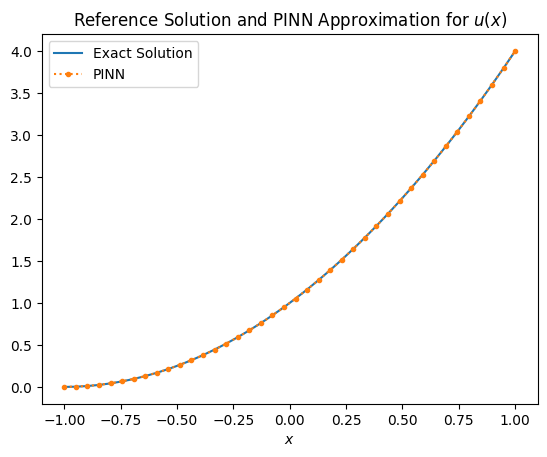

In [46]:
x = np.linspace(-1, 1, samples)

def sol(x):
    return (x + 1)**2

with torch.no_grad():
    X = torch.stack([torch.from_numpy(x).float()], axis=-1)
    Y = mlp(X)

result = Y.detach().numpy()

plt.figure()
plt.plot(x, sol(x), '-', label = 'Exact Solution')
plt.plot(x, result, '.:', label = 'PINN')
plt.title('Reference Solution and PINN Approximation for $u(x)$')
plt.xlabel('$x$')
plt.legend()